## Load Data

We load the initial training data. Skip this entire section if the train model is available under `analysis_best_model/best_model_bayesian_optimization.h5` and jump down to <font style="font-size:13pt; font-weight: bold">Load The Model<font>

### Calculating Fingerprints

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

supplier = Chem.SDMolSupplier('data/cas_4337.sdf')
infos = [{} for mol in supplier]
fingerprints = np.array([AllChem.GetMorganFingerprintAsBitVect(supplier[i], 3, nBits=2048, bitInfo=infos[i]) 
                         for i in range(len(supplier))])

### Splitting Dataset

into train and validation sets

In [2]:
valid_ids = [6,   10,   29,   32,   42,   58,   72,   83,   98,  100,  128, 
        145,  148,  168,  171,  205,  208,  237,  244,  285,  290,  291,
         300,  312,  332,  334,  335,  347,  356,  369,  371,  377,  407,
         424,  456,  458,  470,  472,  486,  514,  515,  528,  557,  563,
         599,  610,  616,  628,  640,  701,  704,  722,  764,  794,  818,
         821,  840,  850,  856,  859,  874,  878,  882,  898,  901,  925,
         936,  945,  957,  974,  977, 1013, 1019, 1030, 1038, 1047, 1049,
        1072, 1073, 1100, 1159, 1168, 1187, 1190, 1194, 1201, 1202, 1233,
        1247, 1258, 1264, 1273, 1283, 1288, 1300, 1302, 1319, 1339, 1349,
        1402, 1413, 1416, 1422, 1426, 1435, 1454, 1465, 1483, 1502, 1513,
        1515, 1520, 1548, 1576, 1604, 1606, 1621, 1650, 1695, 1696, 1711,
        1714, 1716, 1725, 1743, 1746, 1752, 1780, 1788, 1794, 1799, 1813,
        1826, 1866, 1886, 1901, 1903, 1921, 1929, 1940, 1969, 1970, 1997,
        1998, 2008, 2010, 2011, 2018, 2023, 2046, 2060, 2064, 2080, 2081,
        2131, 2171, 2182, 2203, 2212, 2224, 2231, 2241, 2246, 2283, 2294,
        2295, 2297, 2327, 2329, 2331, 2349, 2357, 2360, 2365, 2397, 2413,
        2417, 2418, 2421, 2448, 2467, 2510, 2516, 2528, 2533, 2549, 2562,
        2601, 2604, 2606, 2609, 2611, 2632, 2644, 2653, 2677, 2682, 2685,
        2692, 2703, 2708, 2714, 2719, 2726, 2732, 2759, 2761, 2776, 2780,
        2817, 2818, 2829, 2837, 2857, 2858, 2884, 2899, 2902, 2905, 2911,
        2939, 2975, 2977, 2986, 3007, 3009, 3018, 3024, 3038, 3066, 3087,
        3098, 3107, 3117, 3122, 3139, 3157, 3161, 3164, 3217, 3223, 3233,
        3263, 3265, 3271, 3290, 3295, 3307, 3313, 3317, 3321, 3382, 3384,
        3388, 3400, 3409, 3412, 3419, 3423, 3449, 3470, 3487, 3488, 3503,
        3509, 3511, 3539, 3562, 3626, 3637, 3654, 3662, 3663, 3668, 3671,
        3688, 3689, 3695, 3710, 3726, 3743, 3744, 3782, 3791, 3794, 3808,
        3809, 3841, 3849, 3874, 3910, 3912, 3925, 3945, 3950, 3958, 3959,
        3962, 3964, 3967, 3978, 3993, 4009, 4010, 4055, 4057, 4085, 4089,
        4096, 4099, 4107, 4112, 4129, 4135, 4151, 4155, 4196, 4209, 4216,
        4234, 4236, 4251, 4267, 4283, 4317, 4326, 4335
]

In [3]:
X_train = []
X_valid = []
for i in range(len(fingerprints)):
    if i in valid_ids:
        X_valid.append(fingerprints[i])
    else:
        X_train.append(fingerprints[i])
X_train = np.array(X_train)
X_valid = np.array(X_valid)

Collecting the lables from the supplier

In [4]:
y_train, y_valid, i = [], [], 0
for mol in supplier:
    if mol.GetProp("Ames test categorisation") == "mutagen":
        if i in valid_ids:
            y_valid.append(1)
        else:
            y_train.append(1)
    else:
        if i in valid_ids:
            y_valid.append(0)
        else:
            y_train.append(0)
    i+=1
    
y_train = np.array(y_train)
y_valid = np.array(y_valid)

## Optimizing Model's Architecture

Using the Bayesian Inference

In [79]:
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam

from sklearn.metrics import roc_auc_score

import time

from bayes_opt import BayesianOptimization

Here we set the our search space as well as the substitution function

In [115]:
param_reference = {'init': ['lecun_uniform', 'he_uniform'],
             'activation': ['relu', 'sigmoid', 'selu'],
              'optimizer': [SGD, Adam]
                  }

search_space = {'units': (5, 2048), # discrete
                'activation': (0, 2), # categorical
                'optimizer': (0, 2), # categorical
                'lr': (.00001, .2), # continuous
                'n_layers': (2, 15), # discrete
                'epochs': (5, 30), # discrete
                'batch_size': (1, 200), # discrete
                'momentum': (0.001, 0.5), # continuous
                'init': (0, 1), # categorical
                'dropout_rate': (0.0001, 0.9) # continuous
               }



input_dim = X_valid.shape[1]
def train_evaluate_and_auc(units, activation, optimizer, lr, n_layers, epochs, batch_size, momentum, init, dropout_rate):
    # handle categorical
    activation = param_reference['activation'][int(round(activation))]
    optimizer = param_reference['optimizer'][int(round(optimizer))]
    init = param_reference['init'][int(round(init))]
    # handle discrete
    units = int(round(units))
    n_layers = int(round(n_layers))
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    
    # build classifier with corresponding hyperparameters
    keras.backend.clear_session()
    classifier = Sequential()
    classifier.add(
        Dense(units=units, input_dim=input_dim, activation=activation, kernel_initializer=init) # input layer
    )
    # Create an arbitrary number of Hidden Layers
    for n in range(n_layers):
        classifier.add(Dense(units=units, activation=activation))
        classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units=1, activation='sigmoid'))     # Output Layer
    if optimizer == SGD:
        optimizer = SGD(learning_rate=lr, momentum=momentum)
    else:
        optimizer = Adam(learning_rate=lr)
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # FIXME: adjust epochs and batch size
    classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    return roc_auc_score(y_valid, classifier.predict(X_valid))

run and time the Bayesian optimization process.

In [57]:
start_time = time.ctime()
optimization = BayesianOptimization(f=train_evaluate_and_auc, pbounds=search_space, random_state=0)
optimization.maximize(init_points=10, n_iter=30)
print("Bayesian Optimization took {}".format(time.ctime() - start_time))

print(optimization.max)
# for i, res in enumerate(optimization.res):
#     print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | activa... | batch_... | dropou... |  epochs   |   init    |    lr     | momentum  | n_layers  | optimizer |   units   |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7511   |  0.5488   |  38.61    |  0.5822   |  15.45    |  0.4237   |  0.006813 |  0.375    |  4.675    |  0.9637   |  22.25    |
|  2        |  0.7748   |  0.7917   |  31.16    |  0.5544   |  19.26    |  0.07104  |  0.001784 |  0.2081   |  4.498    |  0.7782   |  44.15    |
|  3        |  0.7762   |  0.9786   |  41.97    |  0.4692   |  17.81    |  0.1183   |  0.006759 |  0.2573   |  4.834    |  0.5218   |  23.66    |
|  4        |  0.8575   |  0.2646   |  40.97    |  0.4649   |  15.68    |  0.01879  |  0.006559 |  0.4448   |  3.851    |  0.9437   |  35.68    |
|  5        |  0.6349   |  0.3595   |  27.48    |  0.6581   |  10.6     |  0.6668   |  0.007036 |  0.2842   |  2.387    |  0

### Set of best hyperparameters

Because the optimization treats all hyperparameters in a continuous way, let's convert them into a interpretable way.

In [100]:
import re
def convert_to_interpretable_dict(optimization_max):
    """ Returns an interpretable dictionary given the a single dictionary from the Bayesian Optimization object above
    """
    interpretable_dict = {}
    interpretable_dict['AUC'] = optimization_max['target']
    interpretable_dict['activation'] = param_reference['activation'][int(round(optimization_max['params']['activation']))] # categorical
    interpretable_dict['batch_size'] = int(round(optimization_max['params']['batch_size']))
    interpretable_dict['dropout_rate'] = optimization_max['params']['dropout_rate']
    interpretable_dict['epochs'] = int(round(optimization_max['params']['epochs']))
    interpretable_dict['init'] = param_reference['init'][int(round(optimization_max['params']['init']))] # categorical
    interpretable_dict['lr'] = optimization_max['params']['lr']
    interpretable_dict['momentum'] = optimization_max['params']['momentum']
    interpretable_dict['n_layers'] = int(round(optimization_max['params']['n_layers']))
    interpretable_dict['optimizer'] = re.findall("[A-Z|a-z]+\'", str(param_reference['optimizer'][int(round(optimization_max['params']['optimizer']))]))[0][:-1] # categorical
    interpretable_dict['units'] = int(round(optimization_max['params']['units']))
    return interpretable_dict

Apply a pretty output 

In [103]:
import pandas as pd

interpretable_dict = convert_to_interpretable_dict(optimization.max)
pd.DataFrame.from_dict(interpretable_dict, orient='index', columns=['Best']).T.style.set_caption("Results of Bayesian Optimization: best set of hyperparameters")

,AUC,activation,batch_size,dropout_rate,epochs,init,lr,momentum,n_layers,optimizer,units
Best,0.877166,relu,10,0.1,10,lecun_uniform,0.01,0.6,2,Adam,50


## Running Model on Test set

Make sure to specify the `input_shape` instead of usual `input_dim`. <font style="font-family: georgia; font-weight: normal; font-size: 16pt">Keras</font> has updated there Dense constructor.

In [99]:
from keras import backend as k
# build model with corresponding hyperparameters
k.clear_session()
model = Sequential()
model.add(
    Dense(units=50, input_shape=X_valid[0].shape, activation='relu', kernel_initializer='lecun_uniform') # input layer
)
# Create an arbitrary number of Hidden Layers
for n in range(2):
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))     # Output Layer
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# FIXME: adjust epochs and batch size
model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=0)

### Loading Test set

Run the following 2 cells to load the test set, and then will obtain them in `X_test`, `y_test`

In [5]:
import csv

smiles, y_test = [], []
with open('data/test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        if row[1] != 'smiles':
            # read smiles from the 2nd column
            smiles.append(row[1])
            # read labels from the 3rd column
            y_test.append(row[2])

In [6]:
info_dicts, X_test = [], []
for smile in smiles:
    m = Chem.MolFromSmiles(smile)
    info = {}
    bit_vector = AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048, bitInfo=info)
    X_test.append(bit_vector)
    info_dicts.append(info)
    
X_test = np.array(X_test)
y_test = np.array(y_test, dtype=np.int8)

### Plotting test set ROC

In [82]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

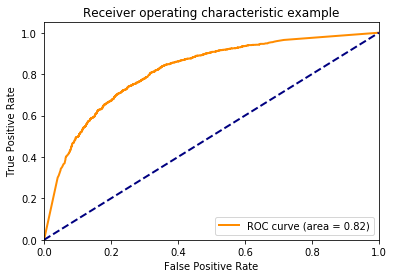

In [83]:
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc(fpr, tpr, auc)

### Saving the model

For later uses. In order not to overwrite my original model, I generate a random number that gets appended to the end of the model's name.

In [162]:
import random
model.save("analysis_best_model/best_model_bayesian_optimization_{}.h5".format(random.randint(1,9999)))

### Load the Model

For later uses

In [7]:
from keras.models import load_model
model = load_model('analysis_best_model/best_model_bayesian_optimization.h5')

Using TensorFlow backend.
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [57]:
type(model.get_weights()[0])

numpy.ndarray

To see model evaluation, look at the cells above.
This was just a sanity check that I'd like to make because th repository has been a mess in the recent while. So in order to check that this model has the same weights as the one reported in my last report, I had to load it and then reevaluate it on the test set, and see if I get the same AUC score.

## Converting Keras Model to Tensorflow

Blackbox function from the Tensorflow documentation that converts a Keras model to a Tensorflow one.

In [197]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 117 variables.
INFO:tensorflow:Converted 117 variables to const ops.


Then we save the tensorflow graph to a file under `model/tf_best_model.pb`

In [198]:
# Save to ./model/tf_best_model.pb
tf.train.write_graph(frozen_graph, "analysis_best_model", "tf_best_model.pb", as_text=False)

'analysis_best_model/tf_best_model.pb'

### Reload the Tensorflow graph model

As of this point, we can forget about the Keras graph model from before.

In [199]:
import tensorflow as tf
from tensorflow.python.platform import gfile

f = gfile.FastGFile("./analysis_best_model/tf_best_model.pb", 'rb')
graph_def = tf.GraphDef()
# Parses a serialized binary message into the current message.
graph_def.ParseFromString(f.read())
f.close()

with tf.Session() as sess:
    sess.graph.as_default()
    # Import a serialized TensorFlow `GraphDef` protocol buffer
    # and place into the current default `Graph`.
    g_in = tf.import_graph_def(graph_def)
    writer = tf.summary.FileWriter('analysis_best_model'+'/log/')
    writer.add_graph(sess.graph)
    writer.flush()
    writer.close()

Instructions for updating:
Use tf.gfile.GFile.


### Visualize the graph

In [200]:
from show_graph import show_graph
import tensorflow as tf
f = gfile.FastGFile("./analysis_best_model/tf_best_model.pb", 'rb')
graph_def = tf.GraphDef()
# Parses a serialized binary message into the current message.
graph_def.ParseFromString(f.read())
# Show current session graph with TensorBoard in Jupyter Notebook.
show_graph(graph_def)

Visualizing the tensorflow graph isn't working

# Integrated Gradients

In the following we provide an implementation for the integrated gradients. Steps of the implementation are:
1. Consider a black image (each pixel 0) as a baseline
2. Now, interpolate a series of images , increasing in intensity, between the baseline image and the original image
3. The scores of these images (softmax output) when plotted, will look like the following.
4. Our region of interest lies where the slope of the score vs intensity graph doesn't remain stagnant. We call these gradients - *interesting gradients*
5. Gradients of the output with respect to these series of interpolated images, when calculated gives us the following
6. The integration of these series of gradients give us the Integrated gradients of the image.


#### Author Implementation

In the following cell, I provide the implementation of the integrated gradients that the author provides (<u>not working</u>).

In [ ]:
import tensorflow as tf
from keras import backend as keras
import numpy as np

def integrated_gradients(inp, baseline, label, steps=50):
    t_input = input_tensor() # input tensor
    t_prediction = prediciton_tensor(label) # output tensor
    t_gradients = tf.gradients(t_prediction, t_input)[0] # gradients
    path_inputs = [baseline + (i/steps)*(inp-baseline) for i in range(steps)]
    grads = run_network(t_gradients, path_inputs)
    return (inp-baseline)*np.average(grads, axis=0) # integration

#### My Implementation (not working)

In the following, I provide my own implementation of the integrated gradients according to my understanding of the math formula in the paper(<u>not working</u>).

In [182]:
from keras import backend as k
import numpy as np

def integrated_gradients(inp, baseline=None, steps=50):
    """My own implementation of the integrated gradients. I've made this over the formula under section "Computing
    Integrated Gradients". Returns the a vector of attributions where each element in the vector corresponds to one
    value in the input. The attributions vector has the same shape as the input.
    @Params
    ------
    inp:    The target input. i.e. One input sample (numpy.array) (e.g. one image, one molecule).
    baseline:      (Optional) The baseline vector - if not provided, the zero-vector is calcualted.
    steps:         (Optional), number of steps for integral estimation. = 50 by default

    @Returns
    -------
    Attribution vector
    """
    gradients = []
    inp = inp.reshape(1, -1) # original input
    if baseline is None:
        baseline = np.zeros(inp.shape)
    # gamma calculates the path function for a given alpha
    gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)

    for alpha in range(steps+1):
        input_tensor = gamma(alpha).reshape(1, -1) # path input tensor
        output_tensor = model.predict(input_tensor) # output tensor
        gradient = k.gradients(model.output, model.input)[0]
        # run the session
        sess = k.get_session()
        results = sess.run(gradient, feed_dict={model.output: output_tensor, model.input: input_tensor})[0]
        gradients.append(results)

    gradients = np.array(gradients)
    return (inp-baseline) * np.average(gradients, axis=0)

To prove the correctness of the method try

$$F(x)-F(x^\prime)=\sum_{i=1}^m a_i$$

Where $a_i$ the $i^{th}$ element in the attribution vector $a = [a_1, a_2, ..., a_m]$

In [183]:
attributions = integrated_gradients(X_test[0])
np.sum(attributions)

-0.11709215719019994

In [184]:
model.predict(X_test[0].reshape(1, -1)) - model.predict(baseline.reshape(1, -1))

array([[-0.11717556]], dtype=float32)

Prove that gamma is working $\gamma(x):R^d \rightarrow [0, 1]$  such that

$$\begin{align}
\gamma(x_i) = 1 &\qquad \text{when} &  x_i &=x \\
\gamma(x_i) = 0 &\qquad \text{when} & x_i &= baseline \\
\end{align}$$

In [141]:
gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)
inp = X_test[478]
baseline = np.zeros(shape=inp.shape)
steps = 50

print("Is gamma equal to input when alpha=1?")
print(gamma(1) == inp)
print("Is gamma equal to baseline when alpha=0?")
print(gamma(0) == baseline)
print("Is gamma equal to baseline when alpha=1?")
print(gamma(1) == baseline)
print("Is gamma equal to input when alpha=0?")
print(gamma(0) == input)

Is gamma equal to input when alpha=1?
[ True  True  True ...  True  True False]
Is gamma equal to baseline when alpha=0?
[ True  True  True ...  True  True  True]
Is gamma equal to baseline when alpha=1?
[ True  True  True ...  True  True False]
Is gamma equal to input when alpha=0?
[False False False ... False False False]


In [48]:
a1 = tf.constant(1.)
a2 = tf.constant(4.)
with tf.GradientTape() as tape:
    tape.watch(a1)
    tape.watch(a2)
    b =  a1**2 + a2
    grad = tape.gradient(b, [a1, a2]) # w.r.t. a1 = 2 * 1 # w.r.t. a2 1
    
with tf.Session() as sess: [print(g.eval()) for g in grad]
# grad

2.0
1.0


This cell is working accordingly.

In [50]:
# %%pixie_debugger
t_input = tf.constant(X_test[0].reshape(1, -1), dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(t_input)
    t_output = model.predict(t_input, steps=1)
    g = tape.gradient(t_output, [t_input])
    
with tf.Session() as sess: [print(g.eval()) for g in grad]

<class 'numpy.ndarray'>


AttributeError: 'numpy.dtype' object has no attribute 'is_floating'

In [118]:
gradient = k.gradients(model.output, model.input)[0]
# iterate = k.function(model.input, [gradient])
sess = k.get_session()
results = sess.run(gradient, feed_dict={model.output: model.predict(X_test[0].reshape(1, -1)), model.input: X_test[0].reshape(1, -1)})

I get the error 
```python
ValueError: Cannot feed value of shape (2048,) for Tensor 'dense_1_input:0', which has shape '(?, 2048)'
```
So in order to change it, we'll change the input shape of the input tensor in the model.

In [72]:
X_test[0].rank

AttributeError: 'numpy.ndarray' object has no attribute 'rank'

## Using GitHub Implemention

Just for the sake of visualization, I'm using this package. However, once my implementation is successfully working, I will change it.

In [125]:
from modules.IntegratedGradients import integrated_gradients as IG
ig = IG(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


(2048,)

In [163]:
attributions = np.array([ig.explain(inp, num_steps=500) for inp in X_test])

Testing the correctness of the implementation

In [164]:
np.sum(attributions[1])

-0.006888923740014433

In [165]:
print(model.predict(X_test[1].reshape(1, -1)) - model.predict(baseline.reshape(1, -1)))

[[-0.00696187]]


Close enough

## Visualizing the Attribution

apparently what needs to be done here is to replace the `DataStructs.TanimotoSimilarity` with the my own attribution score that I get, in order to visualize the attribution correctly. However, I still don't know what type of function that is.

Additionally, I should provide the zero-vector for the reference fingerprints.

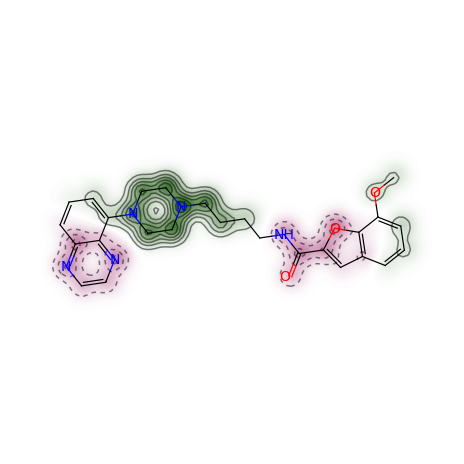

In [138]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs

mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

# fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
#                                                                metric=DataStructs.TanimotoSimilarity)
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
                                                               metric=DataStructs.TanimotoSimilarity)